# Exploring PCA Applied to Neural Recordings

For this dataset, classifying waveform to cell type will be our point of comparison for dimensionality reduction. For each of 13 subjects, approx. 30 neurons are categorized into 3 non-overlapping classes of neurons. 

## Classifying Waveform to Cell Type

In [1]:
import os
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from sklearn.decomposition import PCA
from knn import test_knn

In [2]:
### data setup

path = os.getcwd() # put this file in the same dir as the root dir of the training data
data_root = os.path.join(path,'tactile-coding')
subj_paths = [d for d in os.listdir(data_root) if int(d) <= 12] # only first 12 subjs have EEG data

dataset = []
for i, subj in enumerate(subj_paths):
    subj_path = os.path.join(data_root,subj,'tables')
    
    # already sorted based on source id --> rows correspond in each
    waveforms = pd.read_csv(os.path.join(subj_path,'waveforms.csv'))
    units = pd.read_csv(os.path.join(subj_path,'units.csv'))
    cell_types = units['cellType']
    
    # alignment
    waveforms['sourceId'] = units['sourceId']
    waveforms.set_index('sourceId',inplace = True)
    waveforms.columns = waveforms.columns.astype('float')
    
    waveforms['subj'] = i
    data = pd.concat([waveforms,cell_types],axis=1)
    dataset += [data]

dataset = pd.concat(dataset)    

In [3]:
### summary stats (before feature scaling)

dataset.describe()

,-0.45600007296001166,-0.43200006912001104,-0.40800006528001037,-0.38400006144000975,-0.3600000576000092,-0.3360000537600086,-0.31200004992000796,-0.28800004608000734,-0.2640000422400068,-0.24000003840000614,...,0.6000000960000152,0.6240000998400159,0.6480001036800165,0.6720001075200172,0.6960001113600178,0.7200001152000184,0.7440001190400191,0.7680001228800195,0.7920001267200202,subj
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,...,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,10.029659,8.769840,7.805009,7.920143,9.124554,10.483341,10.740542,9.322774,6.915238,5.221296,...,19.205510,19.423892,18.998948,18.464114,18.294765,18.558847,18.916584,18.901564,18.277156,6.251656
std,7.164416,6.956953,7.115176,7.572240,8.049799,8.337685,8.185313,7.503434,6.866604,7.150363,...,12.439587,12.271126,11.889122,11.578217,11.525188,11.660113,11.776651,11.688350,11.350874,3.664898
min,-9.890981,-11.278459,-12.793783,-14.224825,-15.342163,-16.079247,-16.634413,-17.411121,-18.735771,-20.589755,...,-0.515685,0.901928,0.297399,-1.880569,-3.732465,-3.732060,-1.940554,0.314340,0.626751,0.000000
25%,5.643221,4.367529,3.743892,3.620226,4.834043,5.345053,5.840404,4.708419,2.809788,1.121797,...,10.295801,10.419676,10.456938,10.233866,10.013767,10.191324,10.487156,10.518900,10.097550,3.000000
50%,8.298256,7.284326,6.431137,6.636220,7.651356,9.038336,9.138402,7.749955,5.701304,4.378724,...,17.450666,17.902110,17.838124,17.325793,17.519072,17.665639,17.926998,17.767920,16.820155,6.000000
75%,12.840808,11.761115,10.614292,10.751404,12.082574,13.558721,13.708897,12.236809,9.527960,8.380691,...,24.632616,24.890273,25.681130,25.182700,24.982036,25.435171,25.974895,25.430603,24.213926,10.000000
max,51.237390,49.385873,50.420746,55.145249,58.918286,60.539792,57.710993,52.041033,48.026294,49.693422,...,97.930040,95.034924,87.712003,79.230945,73.445183,71.734186,72.537718,72.485025,68.959097,12.000000


In [4]:
dataset.cellType.describe()

count               302
unique                3
top       RegularSpiker
freq                247
Name: cellType, dtype: object

The input domain has a 53 features, which could benefit from dimensionality reduction. The summary for the cell type categorical labels indicates that regular spikers dominate in the set of recorded waveforms. 

In [5]:
### extraction and preprocessing

X_df = dataset.drop(['cellType','subj'],axis=1)
G_df = dataset['cellType']
features = X_df.columns.values

# feature scaling to standard normal
def standardize(arr):
    return (arr - np.mean(arr,axis=1).reshape(-1,1)) / np.std(arr,axis=1).reshape(-1,1)

X = standardize(X_df.values)
G = G_df.values

y = np.zeros(len(G))
cells = np.unique(G)
for i, cell in enumerate(cells):
    y[G==cell] = i

y = y.astype(int)

In [6]:
### plotting helpers

def meta(title,xlab,ylab):
    sns.despine()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.yticks(range(-4,3,2))
    plt.ylim([-4.5, 3])
    plt.xticks(np.linspace(-0.4,.8,4))
    plt.xlim([-.5, .9])
    plt.title(title)

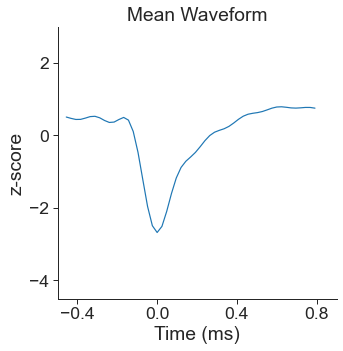

In [7]:
### visualize mean waveform

plt.plot(features,np.mean(X,axis=0))
meta('Mean Waveform','Time (ms)','z-score')
fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig("imgs/mean_waveform.png")

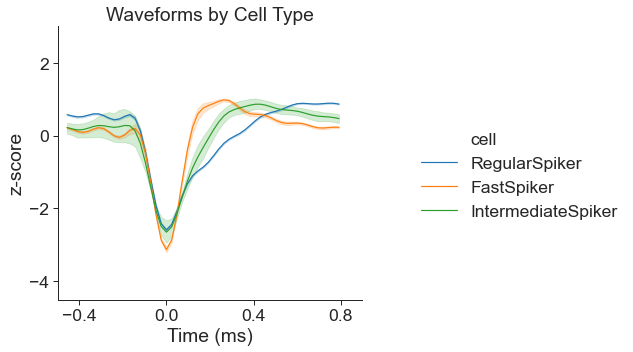

In [8]:
### visualize waveform by cell type

# creating a long-form dataframe for seaborn plotting
points = []
r, c = X.shape
for i in range(r):
    for j in range(c):
        points += [(features[j],X[i,j],G[i])]

norm_data = pd.DataFrame(points,columns=['timepoint','signal','cell'])  

sns.relplot(data=norm_data,x='timepoint',y='signal',hue='cell',kind='line')
meta('Waveforms by Cell Type','Time (ms)','z-score')
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.savefig("imgs/waveform_by_cell_type.png")

Notice that the mean waveform is essentially the same waveform for regular spikers. Alongside the low variance of regular spikers, this info corroborates that regular spikers dominate this dataset. Upon inspection of the data, regular spikers are in fact the most common, followed by fast spikers, and lastly intermediate spikers which only comprise a handful of the measured neurons across all of the subjects. 

## KNN  

Since regular spikers dominate this dataset, the expectation is that KNN alone won't be very accurate in the general case with a balanced dataset. Particularly, the model is not expected to accurately classify intermediate spiking examples since they are underrepresented in the data. 

*Refer to the knn folder for the implementations of a KNN model, hyperparameter selection for K, and testing.*

In [9]:
print("Unstratified:\n")
test_knn(X,y,cells,123)
test_knn(X,y,cells,42)
test_knn(X,y,cells,66)

Unstratified:

Seed = 123
Chosen k:  2
Final accuracy:  0.9032258064516129
Misclassified indices:  [(12, 'FastSpiker', 'IntermediateSpiker'), (13, 'RegularSpiker', 'IntermediateSpiker'), (24, 'IntermediateSpiker', 'RegularSpiker')]
Debug accuracy:  0.988929889298893
Misclassified indices in the form (index, prediction, truth):  [(91, 'FastSpiker', 'IntermediateSpiker'), (239, 'FastSpiker', 'IntermediateSpiker'), (248, 'RegularSpiker', 'IntermediateSpiker')]
Time taken:  2.5038139820098877

Seed = 42
Chosen k:  1
Final accuracy:  0.967741935483871
Misclassified indices:  [(10, 'IntermediateSpiker', 'FastSpiker')]
Debug accuracy:  1.0
Misclassified indices in the form (index, prediction, truth):  []
Time taken:  2.3825042247772217

Seed = 66
Chosen k:  4
Final accuracy:  1.0
Misclassified indices:  []
Debug accuracy:  0.981549815498155
Misclassified indices in the form (index, prediction, truth):  [(87, 'RegularSpiker', 'IntermediateSpiker'), (90, 'FastSpiker', 'IntermediateSpiker'), (16

In [10]:
print("Stratified:\n")
test_knn(X,y,cells,123,stratify=True,n_splits=4)
test_knn(X,y,cells,42,stratify=True,n_splits=4)
test_knn(X,y,cells,66,stratify=True,n_splits=4)

Stratified:

Seed = 123
Chosen k:  2
Final accuracy:  0.9032258064516129
Misclassified indices:  [(12, 'FastSpiker', 'IntermediateSpiker'), (13, 'RegularSpiker', 'IntermediateSpiker'), (24, 'IntermediateSpiker', 'RegularSpiker')]
Debug accuracy:  0.988929889298893
Misclassified indices in the form (index, prediction, truth):  [(51, 'IntermediateSpiker', 'FastSpiker'), (239, 'FastSpiker', 'IntermediateSpiker'), (248, 'RegularSpiker', 'IntermediateSpiker')]
Time taken:  2.6971099376678467

Seed = 42
Chosen k:  1
Final accuracy:  0.967741935483871
Misclassified indices:  [(10, 'IntermediateSpiker', 'FastSpiker')]
Debug accuracy:  1.0
Misclassified indices in the form (index, prediction, truth):  []
Time taken:  2.4513320922851562

Seed = 66
Chosen k:  3
Final accuracy:  1.0
Misclassified indices:  []
Debug accuracy:  0.985239852398524
Misclassified indices in the form (index, prediction, truth):  [(90, 'FastSpiker', 'IntermediateSpiker'), (162, 'RegularSpiker', 'IntermediateSpiker'), (192

By forward selecting K, the model can achieve 100% accuracy on the test set depending on the data split and particularly the seed for the pseudo-rng. Although, if we evaluate the training set with the chosen K, then it sometimes doesn't achieve 100% training accuracy, which implies that the model is generalizable and apparently not overfitting the training data.

Due to the extreme imbalance -- only 4 total intermediate spiker examples -- simply stratifying splits doesn't result in significantly higher classification accuracy of intermediate spiking examples. Interestingly, the performance between statified and unstratified splits is nearly identical. If the results are subpar on an unbalanced dataset, a suggestion would be to implement time-series data augmentation to upsample the unrepresented class.

## PCA

**I should discern and discuss the potential for correlation between the neurons (e.g. neighbors excite neighbors) and the impact that "neurons that wire together, fire together" has on performing dim reduction.**

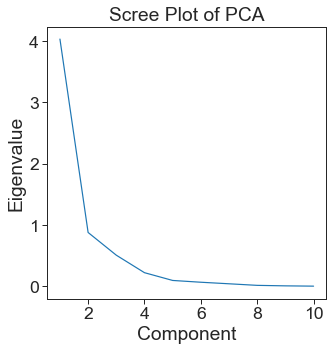

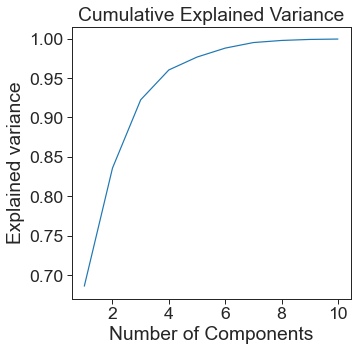

In [11]:
### visualizing PCA to choose the best number of components

pca = PCA(n_components=10)
pca.fit(X)

# pca.explained_variance_ corresponds to the associated eigenvalues of each component

# modified functions from: https://jmausolf.github.io/code/pca_in_python/
def scree_plot(exp_var):

    plt.plot(range(1,len(exp_var)+1),exp_var)
    plt.xlabel('Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot of PCA')
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    fig.savefig("imgs/scree_plot.png")
    plt.show()

def var_explained(exp_var_ratio):

    plt.plot(range(1,len(exp_var_ratio)+1),np.cumsum(exp_var_ratio))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained variance')
    plt.title('Cumulative Explained Variance')
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    fig.savefig("imgs/cumulative_exp_var.png")
    plt.show()

scree_plot(pca.explained_variance_)
var_explained(pca.explained_variance_ratio_)

From the scree plot and cumulative explained variance, the first 3-4 principal components appear to sufficiently explain the data, which is significant reduction from 53 features. For the purposes of visualization, I'm selecting 3 principal components. 

In [12]:
### applying the PCA transformation to the test set and decsribing the new reduced dataset

dim3 = PCA(n_components=3)
X_r = dim3.fit_transform(X)

dim_red_cells = pd.DataFrame(np.hstack([X_r,y.reshape(-1,1)]),columns=['Comp1','Comp2','Comp3','y'])
dim_red_cells.describe()

,Comp1,Comp2,Comp3,y
count,3.020000e+02,3.020000e+02,3.020000e+02,302.000000
mean,-1.409836e-16,5.734927e-17,1.084489e-17,1.655629
std,2.008354e+00,9.371271e-01,7.126743e-01,0.743042
min,-3.684652e+00,-3.755561e+00,-1.967114e+00,0.000000
25%,-1.198454e+00,-6.403898e-01,-4.298324e-01,2.000000
50%,-8.490176e-01,9.846559e-03,-1.427323e-03,2.000000
75%,1.673732e-01,5.427577e-01,3.729705e-01,2.000000
max,5.875948e+00,4.389568e+00,4.639113e+00,2.000000


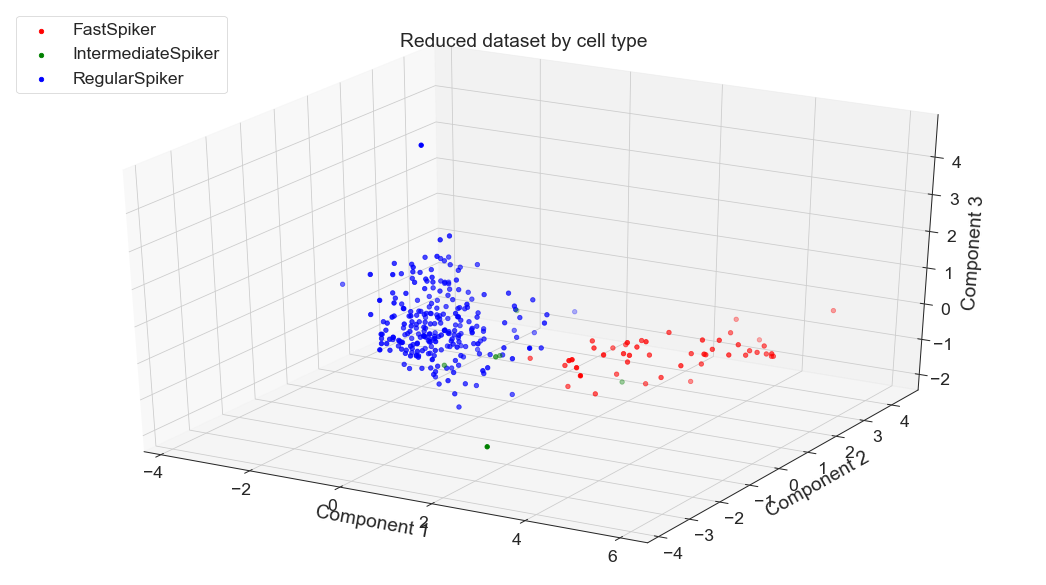

In [13]:
### visualizing the classes in their reduced space

# modified 3D plotting code from: https://stackabuse.com/seaborn-scatter-plot-tutorial-and-examples/
def plot_3d(dim_red_data,labels,title,path):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")

    colors = ['red','green','blue','purple','yellow','lime','orange','cyan','salmon','navy','black','gray','magenta']
    for i in range(len(labels)):
        x_dims = dim_red_data.Comp1[dim_red_data.y==i]
        y_dims = dim_red_data.Comp2[dim_red_data.y==i]
        z_dims = dim_red_data.Comp3[dim_red_data.y==i]

        ax.scatter(x_dims, y_dims, z_dims,color=colors[i],label=labels[i])

    plt.legend(loc="upper left")
    plt.title(title)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig(path)
    plt.show()

plot_3d(dim_red_cells,cells,"Reduced dataset by cell type","imgs/dim_red_cells.png")

In [14]:
### testing out the reduced dataset

print("Unstratified:\n")
test_knn(X_r,y,cells,123)
test_knn(X_r,y,cells,42)
test_knn(X_r,y,cells,66)

Unstratified:

Seed = 123
Chosen k:  2
Final accuracy:  0.9032258064516129
Misclassified indices:  [(12, 'FastSpiker', 'IntermediateSpiker'), (13, 'RegularSpiker', 'IntermediateSpiker'), (24, 'FastSpiker', 'RegularSpiker')]
Debug accuracy:  0.996309963099631
Misclassified indices in the form (index, prediction, truth):  [(248, 'FastSpiker', 'IntermediateSpiker')]
Time taken:  2.5562708377838135

Seed = 42
Chosen k:  7
Final accuracy:  0.967741935483871
Misclassified indices:  [(10, 'RegularSpiker', 'FastSpiker')]
Debug accuracy:  0.974169741697417
Misclassified indices in the form (index, prediction, truth):  [(5, 'RegularSpiker', 'IntermediateSpiker'), (31, 'FastSpiker', 'RegularSpiker'), (41, 'RegularSpiker', 'IntermediateSpiker'), (59, 'FastSpiker', 'IntermediateSpiker'), (104, 'FastSpiker', 'IntermediateSpiker'), (204, 'RegularSpiker', 'IntermediateSpiker'), (260, 'RegularSpiker', 'IntermediateSpiker')]
Time taken:  3.488858222961426

Seed = 66
Chosen k:  5
Final accuracy:  1.0
Mis

In [15]:
print("Stratified:\n")
test_knn(X_r,y,cells,123,stratify=True,n_splits=4)
test_knn(X_r,y,cells,42,stratify=True,n_splits=4)
test_knn(X_r,y,cells,66,stratify=True,n_splits=4)

Stratified:

Seed = 123
Chosen k:  3
Final accuracy:  0.9032258064516129
Misclassified indices:  [(12, 'FastSpiker', 'IntermediateSpiker'), (13, 'RegularSpiker', 'IntermediateSpiker'), (24, 'FastSpiker', 'RegularSpiker')]
Debug accuracy:  0.985239852398524
Misclassified indices in the form (index, prediction, truth):  [(51, 'IntermediateSpiker', 'FastSpiker'), (91, 'FastSpiker', 'IntermediateSpiker'), (239, 'RegularSpiker', 'IntermediateSpiker'), (243, 'RegularSpiker', 'IntermediateSpiker')]
Time taken:  2.4715418815612793

Seed = 42
Chosen k:  3
Final accuracy:  0.967741935483871
Misclassified indices:  [(10, 'IntermediateSpiker', 'FastSpiker')]
Debug accuracy:  0.977859778597786
Misclassified indices in the form (index, prediction, truth):  [(5, 'RegularSpiker', 'IntermediateSpiker'), (31, 'IntermediateSpiker', 'RegularSpiker'), (41, 'RegularSpiker', 'IntermediateSpiker'), (59, 'FastSpiker', 'IntermediateSpiker'), (104, 'FastSpiker', 'IntermediateSpiker'), (260, 'RegularSpiker', 'Int

The results for the reduced dataset are very similar to the unreduced dataset, particularly for seed=123. As expected, the overall performance is less, evinced by imperfect accuracies and more misclassifications, than that with full dimensionality due to the small amount of lost variance. Notably, the majority of the misclassifications revolve around intermediate spikers and, similar to the unreduced classification, the misclassified examples are almost identical between the stratified and unstratified tests. Ultimately, this trend demonstrates that stratification alone isn't sufficient for improving performance on the underrepresented class in a very unbalanced dataset. Interestingly, the time taken to optimize in reduced dimensions is longer on average since higher k values have to be searched in order to find a suitable optimum. 

## Classifying Waveform to Subject

In [16]:
ys = dataset['subj'].values
subjs = np.unique(ys)

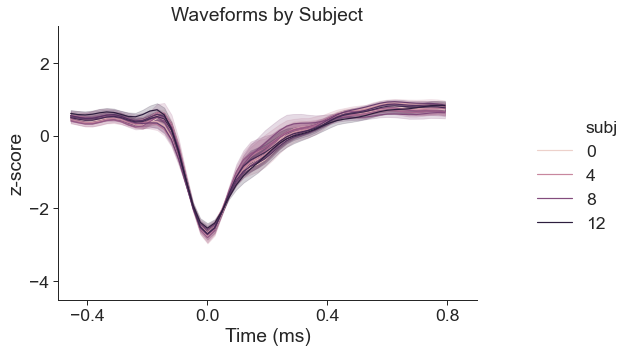

In [17]:
### visualize waveform by cell type

# creating a long-form dataframe for seaborn plotting
points = []
r, c = X.shape
for i in range(r):
    for j in range(c):
        points += [(features[j],X[i,j],ys[i])]

norm_data = pd.DataFrame(points,columns=['timepoint','signal','subj'])  

sns.relplot(data=norm_data,x='timepoint',y='signal',hue='subj',kind='line')
meta('Waveforms by Subject','Time (ms)','z-score')
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.savefig("imgs/waveform_by_subj.png")

In [18]:
dim_red_subjs = pd.DataFrame(np.hstack([X_r,ys.reshape(-1,1)]),columns=['Comp1','Comp2','Comp3','y'])
dim_red_subjs.describe()

,Comp1,Comp2,Comp3,y
count,3.020000e+02,3.020000e+02,3.020000e+02,302.000000
mean,-1.409836e-16,5.734927e-17,1.084489e-17,6.251656
std,2.008354e+00,9.371271e-01,7.126743e-01,3.664898
min,-3.684652e+00,-3.755561e+00,-1.967114e+00,0.000000
25%,-1.198454e+00,-6.403898e-01,-4.298324e-01,3.000000
50%,-8.490176e-01,9.846559e-03,-1.427323e-03,6.000000
75%,1.673732e-01,5.427577e-01,3.729705e-01,10.000000
max,5.875948e+00,4.389568e+00,4.639113e+00,12.000000


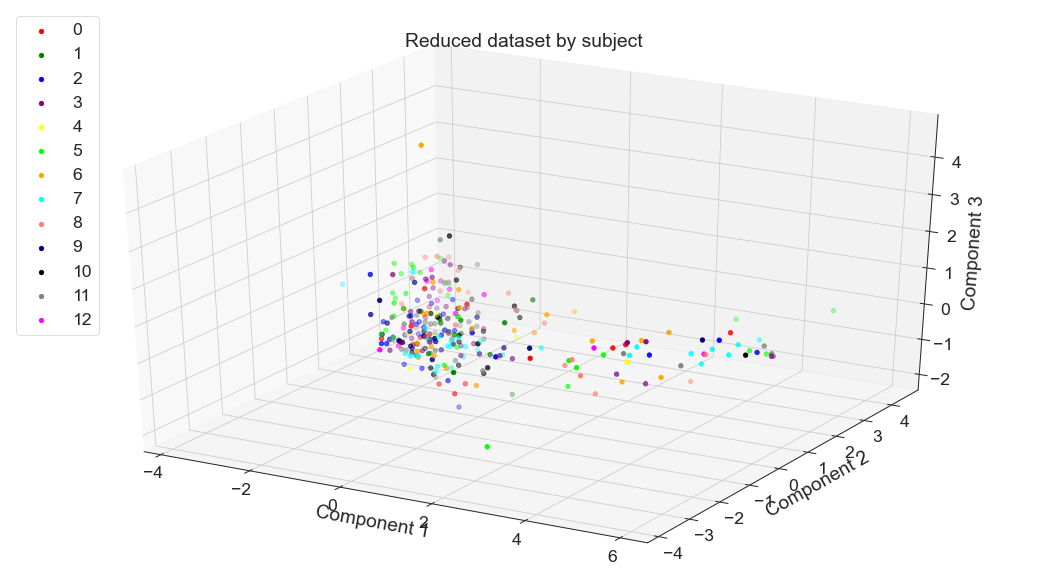

In [19]:
plot_3d(dim_red_subjs,subjs,"Reduced dataset by subject","imgs/dim_red_subjs.png")

Athough classifying waveform to subject is another plausible problem, the waveforms of the subjects heavily overlap, even after reducing to 3 features. Such overlap poses a particular challenge that I will leave as an extension to this project in the future. 